# Task B - Step 3: Create Recommendation Knowledge Base

## Requirements (from project doc)
- Aggregate sentiment by topic and LLM
- Calculate positive experience scores
- Create recommendation matrix
- Output: topic, llm, positive_score for recommendations

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print(" Libraries imported successfully")

 Libraries imported successfully


In [3]:
# from google.colab import files
import pandas as pd


# uploaded = files.upload()

# ---- Read uploaded files ----

df_topics = pd.read_excel("reddit_topics_labeled.xlsx")
df_enriched = pd.read_csv("reddit_llms_enriched.csv")
df_entities = pd.read_csv("reddit_llms_entities.csv")

print("\n✅ Files successfully loaded!")



✅ Files successfully loaded!


In [4]:
df_enriched['id'].duplicated().sum()


np.int64(0)

## Step 1: Load All Data Sources

Load the three key datasets:
1. Task A topics
2. Our enriched data (sentiment + LLM mentions)
3. Entity-level data for detailed analysis

In [5]:
# Load Task A topics (from Shruti)
# If Excel doesn't work, convert to CSV first
try:
    df_topics = pd.read_excel("reddit_topics_labeled.xlsx")
except ImportError:
    print("Installing openpyxl...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'openpyxl'])
    df_topics = pd.read_excel("reddit_topics_labeled.xlsx")

# Load our enriched data from Steps 1 & 2
df_enriched = pd.read_csv("reddit_llms_enriched.csv")

# Load entity-level data
df_entities = pd.read_csv("reddit_llms_entities.csv")

print(" Loaded all data sources")
print(f"\nTask A Topics: {len(df_topics)} posts")
print(f"Enriched Data (Steps 1&2): {len(df_enriched)} posts")
print(f"Entity Mentions: {len(df_entities)} LLM mentions")

 Loaded all data sources

Task A Topics: 2047 posts
Enriched Data (Steps 1&2): 2440 posts
Entity Mentions: 2440 LLM mentions


## Step 2: Merge Topics with Sentiment and LLM Mentions

Combine all three pieces of information into one dataset

In [6]:
# Select relevant columns from topics
# We need: id, topic label
topics_subset = df_topics[['id', 'topic', 'label']].copy()
topics_subset.columns = ['id', 'topic_id', 'topic_label']

# Merge topics with entity data
# This gives us: topic + sentiment + LLM mention
knowledge_base = df_entities.merge(
    topics_subset,
    on='id',
    how='inner'  # Only keep posts that have both topics and entity mentions
)

print(f" Merged data successfully")
print(f"\nKnowledge base shape: {knowledge_base.shape}")
print(f"Columns: {knowledge_base.columns.tolist()}")
print(f"\nSample:")
knowledge_base[['topic_label', 'llm_parent', 'sentiment_label']].head(10)

 Merged data successfully

Knowledge base shape: (2047, 9)
Columns: ['id', 'subreddit', 'sentiment_label', 'sentiment_score', 'llm_parent', 'llm_detected', 'mention_source', 'topic_id', 'topic_label']

Sample:


,topic_label,llm_parent,sentiment_label
0,Pain Point: Interaction Quality & App Issues,ChatGPT,neutral
1,Pain Point: Interaction Quality & App Issues,ChatGPT,negative
2,"Discussion: Usage Limits, Reliability & Subscr...",ChatGPT,neutral
3,Pain Point: Content Filters & Frustrating Inte...,ChatGPT,negative
4,"Discussion: AI Consciousness, Intelligence & P...",ChatGPT,neutral
5,Outlier,Gemini,neutral
6,Pain Point: Interaction Quality & App Issues,ChatGPT,negative
7,"Discussion: AI Consciousness, Intelligence & P...",ChatGPT,neutral
8,Discussion: User Experience & Features (Mobile...,ChatGPT,negative
9,Use Case: Image & Video Generation (Creative),ChatGPT,neutral


## Step 3: Clean and Filter Data

Remove outliers and ensure data quality

In [7]:
# Remove outlier topic (topic_id = -1)
knowledge_base = knowledge_base[knowledge_base['topic_id'] != -1].copy()

# Remove "Outlier" labeled posts
knowledge_base = knowledge_base[knowledge_base['topic_label'] != 'Outlier'].copy()

print(f" Cleaned data")
print(f"Records after filtering: {len(knowledge_base)}")
print(f"\nUnique topics: {knowledge_base['topic_label'].nunique()}")
print(f"Unique LLMs: {knowledge_base['llm_parent'].nunique()}")
print(f"\nTopic distribution:")
print(knowledge_base['topic_label'].value_counts())

 Cleaned data
Records after filtering: 1707

Unique topics: 10
Unique LLMs: 6

Topic distribution:
topic_label
Use Case: Coding & Development                                 463
Discussion: User Experience & Features (Mobile/Voice/Image)    251
Pain Point: Interaction Quality & App Issues                   225
Discussion: Specific LLMs (Grok/xAI), AGI & Probing            210
Discussion: Technical Model Capabilities & Limits              210
Discussion: AI Consciousness, Intelligence & Philosophy        154
Discussion: Usage Limits, Reliability & Subscription Value      91
Use Case: Image & Video Generation (Creative)                   41
Pain Point: Content Filters & Frustrating Interactions          31
Discussion: Specific LLM (DeepSeek) - Usage & Capabilities      31
Name: count, dtype: int64


## Step 4: Calculate Experience Scores

For each (Topic, LLM) combination, calculate:
- Positive experience score = positive / (positive + negative)
- Total mentions
- Sentiment breakdown

In [8]:
# Aggregate by topic and LLM
aggregated = knowledge_base.groupby(
    ['topic_label', 'llm_parent', 'sentiment_label']
).size().reset_index(name='count')

# Pivot to get sentiment columns
sentiment_pivot = aggregated.pivot_table(
    index=['topic_label', 'llm_parent'],
    columns='sentiment_label',
    values='count',
    fill_value=0
).reset_index()

# Calculate metrics
sentiment_pivot['total_mentions'] = (
    sentiment_pivot.get('positive', 0) +
    sentiment_pivot.get('negative', 0) +
    sentiment_pivot.get('neutral', 0)
)

# Calculate positive experience score
# Formula: positive / (positive + negative)
# Note: We exclude neutral from the calculation
sentiment_pivot['positive_experience_score'] = (
    sentiment_pivot.get('positive', 0) /
    (sentiment_pivot.get('positive', 0) + sentiment_pivot.get('negative', 0) + 0.0001)  # Add small epsilon to avoid division by zero
) * 100

# Round for readability
sentiment_pivot['positive_experience_score'] = sentiment_pivot['positive_experience_score'].round(2)

print(" Calculated experience scores")
print(f"\nTotal (Topic, LLM) combinations: {len(sentiment_pivot)}")
print(f"\nSample scores:")
sentiment_pivot[['topic_label', 'llm_parent', 'positive', 'negative', 'neutral',
                 'total_mentions', 'positive_experience_score']].head(15)

 Calculated experience scores

Total (Topic, LLM) combinations: 47

Sample scores:


sentiment_label,topic_label,llm_parent,positive,negative,neutral,total_mentions,positive_experience_score
0,"Discussion: AI Consciousness, Intelligence & P...",ChatGPT,5.0,8.0,28.0,41.0,38.46
1,"Discussion: AI Consciousness, Intelligence & P...",Claude,3.0,4.0,7.0,14.0,42.86
2,"Discussion: AI Consciousness, Intelligence & P...",DeepSeek,10.0,0.0,20.0,30.0,100.00
3,"Discussion: AI Consciousness, Intelligence & P...",Gemini,3.0,4.0,19.0,26.0,42.86
4,"Discussion: AI Consciousness, Intelligence & P...",Grok,8.0,9.0,26.0,43.0,47.06
5,Discussion: Specific LLM (DeepSeek) - Usage & ...,DeepSeek,1.0,18.0,12.0,31.0,5.26
6,"Discussion: Specific LLMs (Grok/xAI), AGI & Pr...",ChatGPT,3.0,4.0,3.0,10.0,42.86
7,"Discussion: Specific LLMs (Grok/xAI), AGI & Pr...",Claude,1.0,0.0,1.0,2.0,99.99
8,"Discussion: Specific LLMs (Grok/xAI), AGI & Pr...",DeepSeek,0.0,0.0,1.0,1.0,0.00
9,"Discussion: Specific LLMs (Grok/xAI), AGI & Pr...",Gemini,0.0,1.0,1.0,2.0,0.00


## Step 5: Filter for Statistical Significance

Only keep combinations with enough mentions (minimum 3) for reliable recommendations

In [10]:
# Set minimum threshold for mentions
MIN_MENTIONS = 3

# Filter for statistical significance
recommendation_base = sentiment_pivot[
    sentiment_pivot['total_mentions'] >= MIN_MENTIONS
].copy()

# Sort by topic and positive score
recommendation_base = recommendation_base.sort_values(
    ['topic_label', 'positive_experience_score'],
    ascending=[True, False]
)

print(f" Filtered for statistical significance (min {MIN_MENTIONS} mentions)")
print(f"\nRecommendation base: {len(recommendation_base)} (Topic, LLM) pairs")
print(f"Filtered out: {len(sentiment_pivot) - len(recommendation_base)} low-frequency pairs")

 Filtered for statistical significance (min 3 mentions)

Recommendation base: 38 (Topic, LLM) pairs
Filtered out: 9 low-frequency pairs


## Step 6: Save Knowledge Base

Save the recommendation knowledge base for Step 4

In [11]:
# Save complete knowledge base
kb_output_path = "recommendation_knowledge_base.csv"
recommendation_base.to_csv(kb_output_path, index=False)

print(f" Saved knowledge base to: {kb_output_path}")
print(f"\nColumns in knowledge base:")
print(recommendation_base.columns.tolist())

 Saved knowledge base to: recommendation_knowledge_base.csv

Columns in knowledge base:
['topic_label', 'llm_parent', 'negative', 'neutral', 'positive', 'total_mentions', 'positive_experience_score']


## Step 7: Analyze Top Recommendations by Topic

For each use case (topic), show the best LLMs

In [12]:
print("="*70)
print("TOP LLM RECOMMENDATIONS BY USE CASE")
print("="*70)

# For each topic, show top 5 LLMs
for topic in recommendation_base['topic_label'].unique():
    topic_data = recommendation_base[recommendation_base['topic_label'] == topic]

    # Get top 5 by positive experience score
    top_5 = topic_data.nlargest(5, 'positive_experience_score')

    print(f"\n{topic}:")
    print("-" * 70)

    for idx, row in top_5.iterrows():
        llm = row['llm_parent']
        score = row['positive_experience_score']
        mentions = row['total_mentions']
        pos = row.get('positive', 0)
        neg = row.get('negative', 0)

        print(f"  {llm:25s}: {score:6.2f}% positive ({pos:3.0f}+ / {neg:3.0f}- from {mentions:3.0f} mentions)")

TOP LLM RECOMMENDATIONS BY USE CASE

Discussion: AI Consciousness, Intelligence & Philosophy:
----------------------------------------------------------------------
  DeepSeek                 : 100.00% positive ( 10+ /   0- from  30 mentions)
  Grok                     :  47.06% positive (  8+ /   9- from  43 mentions)
  Claude                   :  42.86% positive (  3+ /   4- from  14 mentions)
  Gemini                   :  42.86% positive (  3+ /   4- from  26 mentions)
  ChatGPT                  :  38.46% positive (  5+ /   8- from  41 mentions)

Discussion: Specific LLM (DeepSeek) - Usage & Capabilities:
----------------------------------------------------------------------
  DeepSeek                 :   5.26% positive (  1+ /  18- from  31 mentions)

Discussion: Specific LLMs (Grok/xAI), AGI & Probing:
----------------------------------------------------------------------
  ChatGPT                  :  42.86% positive (  3+ /   4- from  10 mentions)
  Grok                     :  30

## Step 8: Create Visualization - Heatmap

Visual representation of LLM performance across use cases

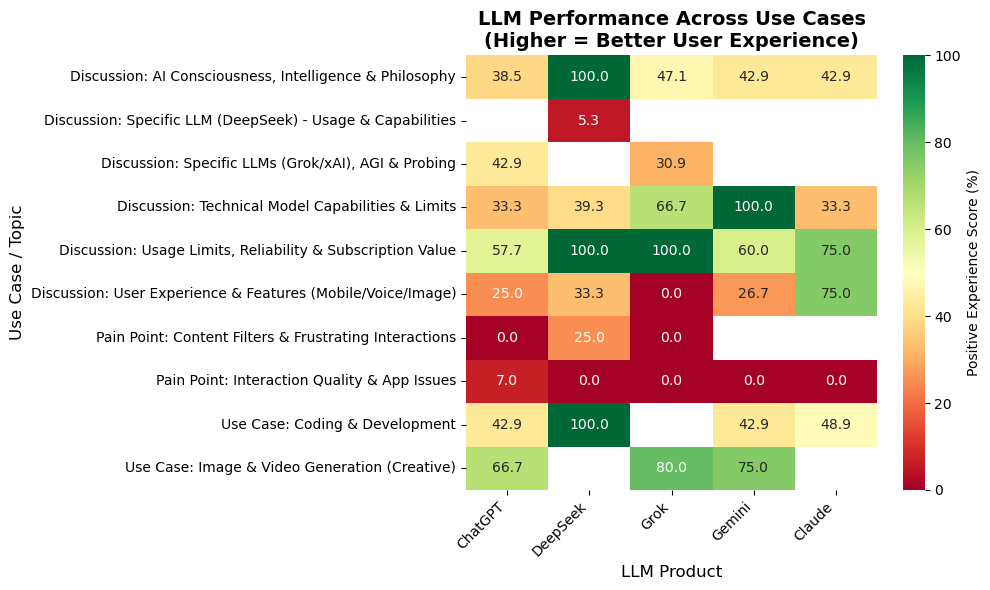

 Heatmap created


In [13]:
# Create pivot table for heatmap: Topic × LLM
heatmap_data = recommendation_base.pivot_table(
    index='topic_label',
    columns='llm_parent',
    values='positive_experience_score',
    aggfunc='mean'
)

# Only show top LLMs (with most coverage)
llm_coverage = recommendation_base.groupby('llm_parent')['topic_label'].nunique()
top_llms = llm_coverage.nlargest(10).index
heatmap_data = heatmap_data[top_llms]

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.1f',
    cmap='RdYlGn',
    vmin=0,
    vmax=100,
    cbar_kws={'label': 'Positive Experience Score (%)'}
)
plt.title('LLM Performance Across Use Cases\n(Higher = Better User Experience)',
          fontsize=14, fontweight='bold')
plt.xlabel('LLM Product', fontsize=12)
plt.ylabel('Use Case / Topic', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(" Heatmap created")

## Step 9: Overall LLM Rankings

Which LLMs have the best overall user satisfaction?

In [12]:
print("="*70)
print("OVERALL LLM RANKINGS")
print("="*70)

# Calculate weighted average score per LLM
# Weight by total mentions
llm_overall = recommendation_base.groupby('entity_canonical').apply(
    lambda x: pd.Series({
        'weighted_score': (x['positive_experience_score'] * x['total_mentions']).sum() / x['total_mentions'].sum(),
        'total_mentions': x['total_mentions'].sum(),
        'num_topics': x['topic_label'].nunique(),
        'avg_positive': x.get('positive', 0).sum(),
        'avg_negative': x.get('negative', 0).sum()
    })
).reset_index()

# Sort by weighted score
llm_overall = llm_overall.sort_values('weighted_score', ascending=False)

print("\nTop 15 LLMs by Overall User Satisfaction:")
print("\nRank | LLM                     | Score  | Topics | Mentions | +/- Ratio")
print("-" * 80)

for rank, (idx, row) in enumerate(llm_overall.head(15).iterrows(), 1):
    llm = row['entity_canonical']
    score = row['weighted_score']
    topics = row['num_topics']
    mentions = row['total_mentions']
    pos = row['avg_positive']
    neg = row['avg_negative']
    ratio = pos / (neg + 0.1)  # Avoid division by zero

    print(f"{rank:4d} | {llm:23s} | {score:5.1f}% | {topics:6.0f} | {mentions:8.0f} | {ratio:6.2f}")

OVERALL LLM RANKINGS

Top 15 LLMs by Overall User Satisfaction:

Rank | LLM                     | Score  | Topics | Mentions | +/- Ratio
--------------------------------------------------------------------------------
   1 | Meta                    | 100.0% |      2 |        6 |  30.00
   2 | Grok-2                  | 100.0% |      1 |        9 |  10.00
   3 | Anthropic               |  69.8% |      3 |       59 |   3.11
   4 | Claude                  |  55.6% |      7 |      565 |   1.16
   5 | Google                  |  50.0% |      1 |        3 |   0.91
   6 | xAI                     |  47.2% |      2 |       79 |   0.99
   7 | DeepSeek                |  46.5% |      6 |      673 |   0.79
   8 | Gemini                  |  41.5% |     10 |      274 |   0.78
   9 | Grok                    |  35.9% |      8 |      591 |   0.56
  10 | ChatGPT                 |  32.8% |      8 |      140 |   0.52
  11 | DeepSeek-R1             |  27.3% |      1 |       17 |   0.37
  12 | GPT-4           

## Step 10: Topic Coverage Analysis

Which topics have the most LLM discussions?

In [13]:
print("="*70)
print("TOPIC COVERAGE ANALYSIS")
print("="*70)

# Aggregate by topic
topic_stats = recommendation_base.groupby('topic_label').agg({
    'entity_canonical': 'nunique',  # Number of unique LLMs
    'total_mentions': 'sum',        # Total mentions
    'positive': 'sum',              # Total positive
    'negative': 'sum'               # Total negative
}).reset_index()

topic_stats.columns = ['topic', 'num_llms', 'total_mentions', 'positive', 'negative']

# Calculate overall positive rate
topic_stats['positive_rate'] = (
    topic_stats['positive'] / (topic_stats['positive'] + topic_stats['negative'])
) * 100

# Sort by mentions
topic_stats = topic_stats.sort_values('total_mentions', ascending=False)

print("\nTopics by Discussion Volume:")
print("\nTopic                                      | LLMs | Mentions | Positive Rate")
print("-" * 75)

for idx, row in topic_stats.iterrows():
    print(f"{row['topic']:35s}        | {row['num_llms']:4.0f}   | {row['total_mentions']:8.0f}   | {row['positive_rate']:6.1f}%")

TOPIC COVERAGE ANALYSIS

Topics by Discussion Volume:

Topic                                      | LLMs | Mentions | Positive Rate
---------------------------------------------------------------------------
Discussion: Model Tech                     |    8   |      666   |   42.1%
Use Case: File Handling (PDF)              |    8   |      625   |   30.6%
Use Case: Coding/Dev                       |    6   |      571   |   58.8%
Use Case: Abstract Reasoning               |    8   |      196   |   52.5%
Junk: Image Links                          |    3   |      170   |   32.6%
Use Case: Advanced Workflows               |    5   |       82   |   90.9%
Pain Point: Image Gen Filters/Quality        |    2   |       38   |    0.0%
Use Case: Creative Media Gen               |    3   |       30   |   91.7%
Discussion: Subscriptions/Billing          |    4   |       25   |   60.9%
Pain Point: Chat History Bugs              |    2   |       13   |   60.0%
Use Case: Factual Q&A                   

## Step 11: Create Recommendation Function (Preview for Step 4)

Sample function showing how Step 4 will use this knowledge base

In [14]:
def get_recommendations(topic_label, top_n=3, min_score=50):
    """
    Get top N LLM recommendations for a given use case

    Parameters:
    - topic_label: Use case name (e.g., 'Use Case: Coding')
    - top_n: Number of recommendations to return
    - min_score: Minimum positive experience score threshold

    Returns:
    - DataFrame with top recommendations
    """
    # Filter by topic
    topic_recs = recommendation_base[
        (recommendation_base['topic_label'] == topic_label) &
        (recommendation_base['positive_experience_score'] >= min_score)
    ]

    # Sort by score and return top N
    top_recs = topic_recs.nlargest(top_n, 'positive_experience_score')

    return top_recs[['entity_canonical', 'positive_experience_score', 'total_mentions']]

# Test the function
print("\n" + "="*70)
print("SAMPLE RECOMMENDATIONS")
print("="*70)

# Test with a few topics
test_topics = recommendation_base['topic_label'].unique()[:3]

for topic in test_topics:
    print(f"\nQuery: '{topic}'")
    recs = get_recommendations(topic, top_n=3)

    if len(recs) > 0:
        print("\nRecommended LLMs:")
        for idx, row in recs.iterrows():
            print(f"  {idx+1}. {row['entity_canonical']:20s} - {row['positive_experience_score']:.1f}% positive ({row['total_mentions']:.0f} mentions)")
    else:
        print("  No recommendations found (insufficient data)")


SAMPLE RECOMMENDATIONS

Query: 'Discussion: Model Tech'

Recommended LLMs:
  9. Meta                 - 100.0% positive (3 mentions)
  3. Claude               - 83.3% positive (20 mentions)
  7. Gemini               - 80.0% positive (10 mentions)

Query: 'Discussion: Subscriptions/Billing'

Recommended LLMs:
  11. ChatGPT              - 100.0% positive (3 mentions)
  15. Grok                 - 100.0% positive (5 mentions)
  14. Google               - 50.0% positive (3 mentions)

Query: 'Junk: Image Links'

Recommended LLMs:
  16. ChatGPT              - 57.1% positive (17 mentions)


In [15]:
print("="*70)
print(" TASK B STEP 3 COMPLETE!")
print("="*70)

print(f"\n Knowledge Base Statistics:")
print(f"   Total (Topic, LLM) pairs: {len(recommendation_base)}")
print(f"   Unique topics: {recommendation_base['topic_label'].nunique()}")
print(f"   Unique LLMs: {recommendation_base['entity_canonical'].nunique()}")
print(f"   Total mentions analyzed: {recommendation_base['total_mentions'].sum():.0f}")

print(f"\n Output file: recommendation_knowledge_base.csv")
print(f"\n Ready for Step 4: Semantic Search Recommender System")

 TASK B STEP 3 COMPLETE!

 Knowledge Base Statistics:
   Total (Topic, LLM) pairs: 50
   Unique topics: 11
   Unique LLMs: 12
   Total mentions analyzed: 2421

 Output file: recommendation_knowledge_base.csv

 Ready for Step 4: Semantic Search Recommender System


In [17]:
# Verify the output file
kb = pd.read_csv("recommendation_knowledge_base.csv")
print(f"Knowledge base has {len(kb)} (Topic, LLM) pairs")
print(f"\nSample recommendations:")
print(kb[['topic_label', 'entity_canonical', 'positive_experience_score', 'total_mentions']].head(10))

Knowledge base has 50 (Topic, LLM) pairs

Sample recommendations:
                         topic_label entity_canonical  \
0             Discussion: Model Tech             Meta   
1             Discussion: Model Tech           Claude   
2             Discussion: Model Tech           Gemini   
3             Discussion: Model Tech             Grok   
4             Discussion: Model Tech          ChatGPT   
5             Discussion: Model Tech         DeepSeek   
6             Discussion: Model Tech      DeepSeek-R1   
7             Discussion: Model Tech        Anthropic   
8  Discussion: Subscriptions/Billing          ChatGPT   
9  Discussion: Subscriptions/Billing             Grok   

   positive_experience_score  total_mentions  
0                      99.99             3.0  
1                      83.33            20.0  
2                      80.00            10.0  
3                      66.67            14.0  
4                      42.11            35.0  
5                      4

In [18]:
print("="*70)
print("FINAL TASK B (STEPS 1-3) SUMMARY")
print("="*70)

print("\n Step 1: Sentiment Analysis")
print(f"   - Output: reddit_llms_with_sentiment.csv")
print(f"   - Method: RoBERTa Transformer")

print("\n Step 2: Named Entity Recognition")
print(f"   - Output: reddit_llms_entities.csv")
print(f"   - Output: reddit_llms_enriched.csv")

print("\n Step 3: Knowledge Base")
print(f"   - Output: recommendation_knowledge_base.csv")
print(f"   - Total pairs: {len(kb)}")
print(f"   - Unique topics: {kb['topic_label'].nunique()}")
print(f"   - Unique LLMs: {kb['entity_canonical'].nunique()}")

print("\n Top 3 Recommendations by Score:")
top_3 = kb.nlargest(3, 'positive_experience_score')
for idx, row in top_3.iterrows():
    print(f"   {row['topic_label']:40s} → {row['entity_canonical']:15s}: {row['positive_experience_score']:.1f}%")


FINAL TASK B (STEPS 1-3) SUMMARY

 Step 1: Sentiment Analysis
   - Output: reddit_llms_with_sentiment.csv
   - Method: RoBERTa Transformer

 Step 2: Named Entity Recognition
   - Output: reddit_llms_entities.csv
   - Output: reddit_llms_enriched.csv

 Step 3: Knowledge Base
   - Output: recommendation_knowledge_base.csv
   - Total pairs: 50
   - Unique topics: 11
   - Unique LLMs: 12

 Top 3 Recommendations by Score:
   Discussion: Subscriptions/Billing        → ChatGPT        : 100.0%
   Discussion: Subscriptions/Billing        → Grok           : 100.0%
   Pain Point: Chat History Bugs            → Claude         : 100.0%
